# EDA & Datarensning

### Utforskande dataanalys och förberedelse av data för taxi-prisprojektet.
### Syftet med denna notebook är att:

- förstå datasetets struktur
- identifiera saknade värden och avvikelser
- rensa och förbereda datan så den kan användas i modellen och i appen

### 1. Ladda in datasetet
Vi läser in datasetet och visar de första raderna för att få en första överblick.


In [227]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
from taxipred.utils.constants import TAXI_CSV_PATH, DATA_PATH

df = pd.read_csv(TAXI_CSV_PATH)
df.head()

,Trip_Distance_km,Time_of_Day,Day_of_Week,Passenger_Count,Traffic_Conditions,Weather,Base_Fare,Per_Km_Rate,Per_Minute_Rate,Trip_Duration_Minutes,Trip_Price
0,19.35,Morning,Weekday,3.0,Low,Clear,3.56,0.80,0.32,53.82,36.2624
1,47.59,Afternoon,Weekday,1.0,High,Clear,NaN,0.62,0.43,40.57,NaN
2,36.87,Evening,Weekend,1.0,High,Clear,2.70,1.21,0.15,37.27,52.9032
3,30.33,Evening,Weekday,4.0,Low,NaN,3.48,0.51,0.15,116.81,36.4698
4,NaN,Evening,Weekday,3.0,High,Clear,2.93,0.63,0.32,22.64,15.6180


Datasetet innehåller 1000 rader och 11 kolumner.


## 2. Datasetets struktur & saknade värden

I detta steg undersöker vi:
- vilka kolumner som finns i datasetet  
- vilka datatyper de har  
- hur många värden som saknas i varje kolumn  

Detta ger oss en grund för hur datan behöver rensas och förberedas innan modellträning.

Resultatet visar att:
- datasetet innehåller **1000 rader och 11 kolumner**
- flera kolumner saknar ungefär **50 värden**
- `Trip_Price` saknar **49 värden** — dessa rader kommer senare användas som användar-input i appen
- datasetet innehåller både numeriska och kategoriska variabler

Denna information används som underlag för nästa steg: datarensning.


In [228]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   Trip_Distance_km       950 non-null    float64
 1   Time_of_Day            950 non-null    object 
 2   Day_of_Week            950 non-null    object 
 3   Passenger_Count        950 non-null    float64
 4   Traffic_Conditions     950 non-null    object 
 5   Weather                950 non-null    object 
 6   Base_Fare              950 non-null    float64
 7   Per_Km_Rate            950 non-null    float64
 8   Per_Minute_Rate        950 non-null    float64
 9   Trip_Duration_Minutes  950 non-null    float64
 10  Trip_Price             951 non-null    float64
dtypes: float64(7), object(4)
memory usage: 86.1+ KB


## 3. Statistisk sammanfattning

I detta steg analyserar vi grundläggande statistik för de numeriska kolumnerna i datasetet.
Syftet är att förstå:
- hur värdena är fördelade
- om det finns extrema värden (outliers)
- om några kolumner beter sig onormalt

Statistiken visar bland annat att:

- Reslängder och restider varierar kraftigt mellan olika resor
- `Trip_Price` har ett relativt högt maxvärde jämfört med medianen, vilket tyder på möjliga outliers
- Fördelningarna är rimliga men vissa värden sticker ut och bör hanteras i nästa steg

Denna analys används för att avgöra hur vi ska rensa datan och hantera extrema värden innan modellträning.

In [229]:
df.describe().T.drop(["count"], axis =1)

,mean,std,min,25%,50%,75%,max
Trip_Distance_km,27.070547,19.905300,1.2300,12.63250,25.8300,38.40500,146.067047
Passenger_Count,2.476842,1.102249,1.0000,1.25000,2.0000,3.00000,4.000000
Base_Fare,3.502989,0.870162,2.0100,2.73000,3.5200,4.26000,5.000000
Per_Km_Rate,1.233316,0.429816,0.5000,0.86000,1.2200,1.61000,2.000000
Per_Minute_Rate,0.292916,0.115592,0.1000,0.19000,0.2900,0.39000,0.500000
Trip_Duration_Minutes,62.118116,32.154406,5.0100,35.88250,61.8600,89.05500,119.840000
Trip_Price,56.874773,40.469791,6.1269,33.74265,50.0745,69.09935,332.043689


In [230]:
#Visar grundläggande statistik för priset så vi kan se spridning och möjliga extremvärden.
df["Trip_Price"].describe()


count    951.000000
mean      56.874773
std       40.469791
min        6.126900
25%       33.742650
50%       50.074500
75%       69.099350
max      332.043689
Name: Trip_Price, dtype: float64

## 4. Visualisering av data


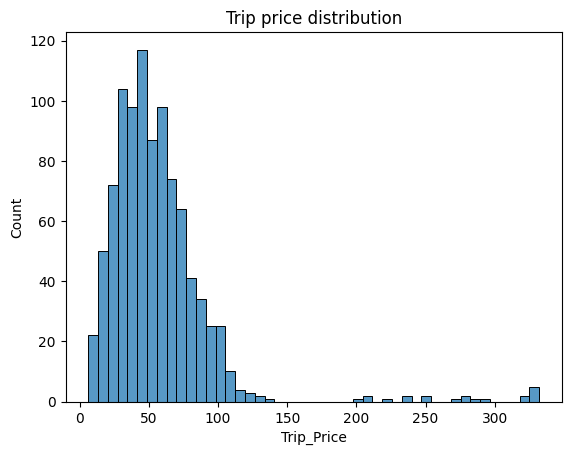

In [231]:
sns.histplot(df["Trip_Price"])
plt.title("Trip price distribution")
plt.show()


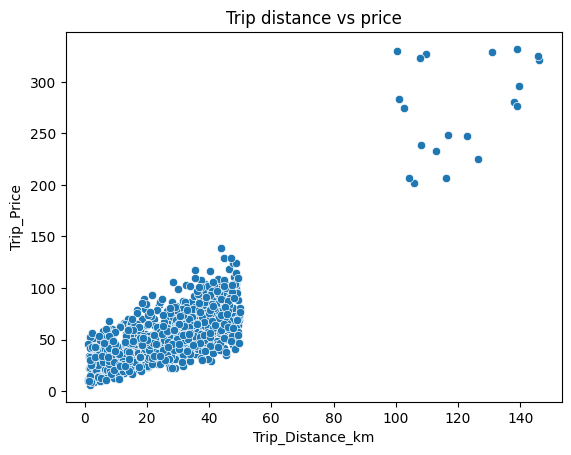

In [232]:
sns.scatterplot(data=df, x="Trip_Distance_km", y="Trip_Price")
plt.title("Trip distance vs price")
plt.show()


## 3. Prisanalys och rensning

I detta steg analyserar vi målvariabeln *Trip_Price*, identifierar saknade värden och outliers, 
rensar datan och förbereder ett träningsdataset som kan användas av modellen.


In [233]:
df.isna().sum()


Trip_Distance_km         50
Time_of_Day              50
Day_of_Week              50
Passenger_Count          50
Traffic_Conditions       50
Weather                  50
Base_Fare                50
Per_Km_Rate              50
Per_Minute_Rate          50
Trip_Duration_Minutes    50
Trip_Price               49
dtype: int64

Delar upp datan i rader med pris (för träning) och utan pris (kan användas som framtida användar-input).


In [234]:
has_price = df["Trip_Price"].notna()
missing_price = df["Trip_Price"].isna()

df_labeled = df[has_price]
df_no_label = df[missing_price]

df_labeled.shape, df_no_label.shape

((951, 11), (49, 11))

Kontrollerar hur många saknade värden som finns kvar i träningsdatan.


In [235]:
df_labeled.isna().sum()


Trip_Distance_km         50
Time_of_Day              49
Day_of_Week              46
Passenger_Count          48
Traffic_Conditions       50
Weather                  46
Base_Fare                44
Per_Km_Rate              44
Per_Minute_Rate          49
Trip_Duration_Minutes    46
Trip_Price                0
dtype: int64

Tar bort rader som fortfarande innehåller saknade värden.


In [236]:
df_labeled_clean = df_labeled.dropna()

df_labeled.shape, df_labeled_clean.shape


((951, 11), (562, 11))

In [237]:
df_labeled_clean["Trip_Price"].describe()


count    562.000000
mean      57.663525
std       43.958741
min        6.126900
25%       33.583875
50%       50.157850
75%       69.146575
max      332.043689
Name: Trip_Price, dtype: float64

Tar bort extremt höga priser som kan försämra modellens inlärning.


In [238]:
df_labeled_clean = df_labeled_clean[df_labeled_clean["Trip_Price"] <= 200]


In [239]:
df_labeled_clean.shape


(548, 11)

Väljer endast de kolumner som modellen ska använda.


In [240]:
selected_columns = [
    "Trip_Distance_km",
    "Time_of_Day",
    "Day_of_Week",
    "Passenger_Count",
    "Traffic_Conditions",
    "Weather",
    "Trip_Duration_Minutes",
    "Trip_Price"
]

df_model = df_labeled_clean[selected_columns]
df_model.shape


(548, 8)

Väljer endast de kolumner som modellen ska använda.


In [241]:
df_model.to_csv(DATA_PATH/"taxi_train_clean.csv", index=False)
